In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

## Load and examine Vehicle insurance data

In this notebook we use a data set consisting of 67856 insurance policies and 4624 (6.8%) claims in Australia between 2004 and 2005. The original source of this dataset is the book [Generalized Linear Models for Insurance Data](http://www.businessandeconomics.mq.edu.au/our_departments/Applied_Finance_and_Actuarial_Studies/research/books/GLMsforInsuranceData) by Piet de Jong and Gillian Z. Heller. 

In [3]:
data = pd.read_csv("data/carclaims.csv")
data.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2


Let's see the meaning of the variables before creating any plot or fitting any model.

* **veh_value**: Vehicle value, ranges from \\$0 to \\$350,000.
* **exposure**: Proportion of the year where the policy was exposed. In practice each policy is not exposed for the full year. Some policies come into force partly into the year while others are canceled before the year’s end.
* **clm**: Claim occurrence. 0 (no), 1 (yes).
* **numclaims**: Number of claims.
* **claimcst0**: Claim amount. 0 if no claim. Ranges from \\$200 to \\$55922.
* **veh_body**: Vehicle body type. Can be one of bus, convertible, coupe, hatchback, hardtop, motorized caravan/combi, minibus, panel van, roadster, sedan, station wagon, truck, and utility.
* **veh_age**: Vehicle age. 1 (new), 2, 3, and 4.
* **gender**: Gender of the driver. M (Male) and F (Female).
* **area**: Driver's area of residence. Can be one of A, B, C, D, E, and F.
* **agecat**: Driver's age category. 1 (youngest), 2, 3, 4, 5, and 6.

The variable of interest is the claim amount. We keep the records where there is a claim, so claim amount is greater than 0. 

In [4]:
data = data[data["claimcst0"] > 0]

For clarity, we only show those claims amounts below \\$15,000, since there are only 65 records above that threshold.

In [5]:
len(data[data["claimcst0"] > 15000])

65

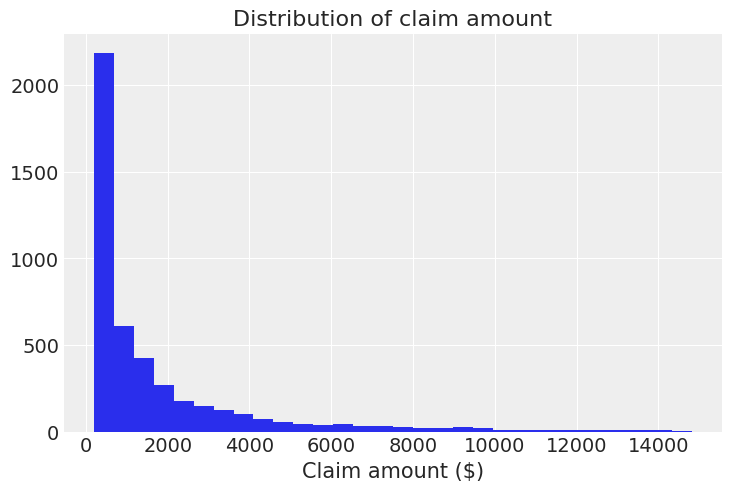

In [6]:
plt.hist(data[data["claimcst0"] <= 15000]["claimcst0"], bins=30)
plt.title("Distribution of claim amount")
plt.xlabel("Claim amount ($)");

And this is when you say: "Oh, there really are ugly right-skewed distributions out there!". Well, yes, we've all been there :)

## Wald family


The Wald family (a.k.a inverse Gaussian model) states that 

$$
\begin{array}{cc}
y_i \sim \text{Wald}(\mu_i, \lambda) & g(\mu_i) = \mathbf{x_i}^T\beta
\end{array}
$$

where the canonical link is $g(\mu_i) = \mu_i^{-2}$, but $g(\mu_i) = \log(\mu_i)$ is usually preferred, and it is what we use here.

## Model fit

In [12]:
model = bmb.Model("claimcst0 ~ C(agecat) + gender + area", data, family = "wald", link = "log")
fitted = model.fit(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [claimcst0_lam, area, gender, C(agecat), Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 21 seconds.


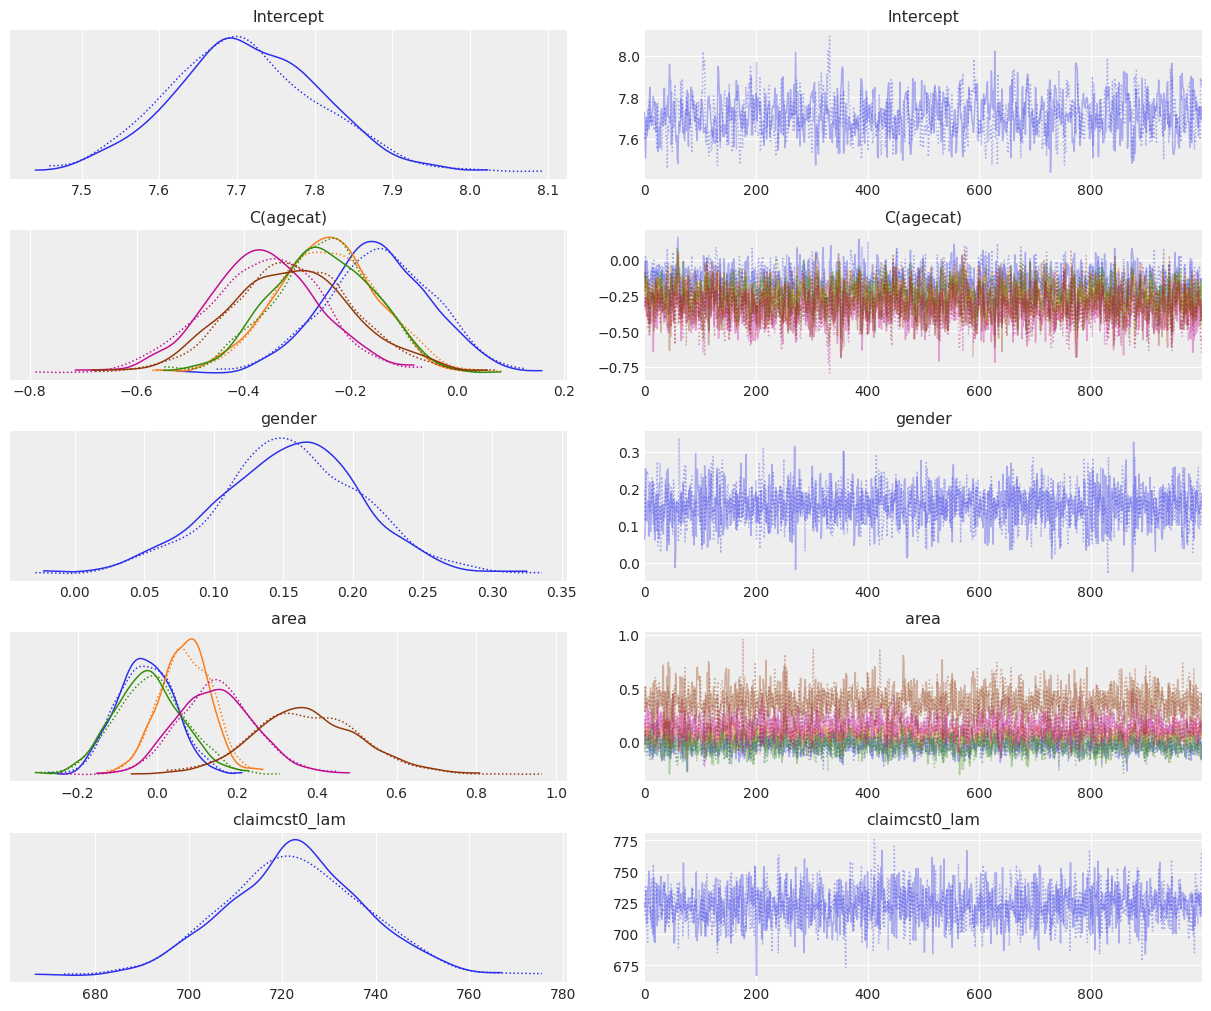

In [13]:
az.plot_trace(fitted);

In [9]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.713,0.096,7.537,7.890,0.005,0.003,404.0,725.0,1.0
C(agecat)[2],-0.146,0.096,-0.326,0.027,0.004,0.003,590.0,991.0,1.0
C(agecat)[3],-0.243,0.097,-0.428,-0.069,0.004,0.003,530.0,1006.0,1.0
C(agecat)[4],-0.249,0.095,-0.422,-0.069,0.004,0.003,752.0,725.0,1.0
C(agecat)[5],-0.364,0.104,-0.564,-0.173,0.004,0.003,687.0,784.0,1.0
C(agecat)[6],-0.305,0.117,-0.535,-0.094,0.004,0.003,844.0,1166.0,1.0
gender,0.153,0.050,0.057,0.243,0.001,0.001,1352.0,1040.0,1.0
area[B],-0.033,0.073,-0.166,0.104,0.002,0.002,1165.0,1029.0,1.0
area[C],0.064,0.067,-0.061,0.185,0.002,0.001,1040.0,909.0,1.0
area[D],-0.027,0.090,-0.184,0.148,0.003,0.002,1122.0,1100.0,1.0
